In [158]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random

import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# Submission for AI for SEA - Problem: Safety

Name: Hani Ramadhan

Email: hani.its.042@gmail.com

## Table of contents

[0. Data Loading](#preprocess)

[0.1 Data Cleaning on labels](#clean-labels)

[1. Problem Definition and Assumption](#assumptions)

[2. Data Cleaning & Smoothing](#smoothing)

[3. Introducing new features](#new-features)

[4. Exploratory Data Analysis ](#eda)(Checking each features'/label distribution)

[5. Experiments & Feature Selection](#exp)

[6. Real-world-like approach: Early Unsafe Driving Detection](#realworld)

[7. Final Thoughts](#final)

-----------------------------

#### Investigation using EDA (Exploratory Data Analysis):
1. Does high acceleration (both from accelerometer-resultant & Speed-derivation) makes drive unsafe?
3. Does high change of angle (from gyroscope) makes drive unsafe?
4. Do we need fusion from GPS+digital sensors?

<a id='preprocess'></a>
# 0. Data Loading

Features data

In [113]:
frames = []

for i in range(10) :
    df = pd.read_csv('../features/part-0000'+str(i)+'-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
    frames.append(df)
    
df = pd.concat(frames)
df = df.sort_values(by=['bookingID', 'second']) #we sort it by bookingID and seconds by convenience
df = df.reset_index(drop=True)
   

In [114]:
df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454


We would like to check the size of the recorded trip data, signified by the bookingID. Number of bookingIDs = 20000

In [115]:
print("Total trip data: " + str(df.shape[0]) + " rows")
print("Total bookings: " + str(df.groupby(['bookingID'],as_index=False).count().shape[0]))

Total trip data: 16135561 rows
Total bookings: 20000


Label data

In [116]:
label = pd.read_csv('../labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv',index_col=False)
label = label.sort_values(by=['bookingID'])
label = label.reset_index(drop=True)

In [117]:
label.head()

,bookingID,label
0,0,0
1,1,1
2,2,1
3,4,1
4,6,0


Investigating the label distribution

In [118]:
label.groupby(['label']).count()

,bookingID
label,
0,15017
1,5001


Most of the labels are 0, with the ratio of 3:1. But, it seems suspicious that the total number of bookingID does not add up.

(Labels' total bookingID) 15017 + 5001 = 20018 $\neq$ 20000 (Features' total bookingID)

<a id='clean-labels'></a>
## 0.1. Data Cleaning on Labels

### Warning! Unclean Data!

The number of the bookings in the features data is smaller than the labels data.
Let's check the duplicate bookingID/labels!


In [119]:
bookingCount = label.groupby(['bookingID']).count()

#Showing IDs with duplicate labels
dupIDs = bookingCount[bookingCount>1].dropna().reset_index()['bookingID']

#Showing the labels of duplicate labels
label[label['bookingID'].isin(dupIDs)]

,bookingID,label
9,13,1
10,13,0
2124,154618822837,0
2125,154618822837,1
3031,223338299461,1
3032,223338299461,0
5124,395136991308,0
5125,395136991308,1
5242,403726925929,0
5243,403726925929,1


Turns out that the duplicate labels (18x2) are all different. We will take the **final value** (maybe it is an error?).

In [120]:
#choosing the final value only
lastPick = label[label['bookingID'].isin(dupIDs)].reset_index(drop=True).iloc[1::2]

#We only change the duplicate ID whose final label is 1, why? We'll use MIN aggregate groupby later.
lastPickIDs1 = lastPick.loc[lastPick['label']==1,'bookingID'].reset_index(drop=True)

labelc = label.groupby(['bookingID'],as_index=False).min() #cleaned label
labelc.loc[labelc['bookingID'].isin(lastPickIDs1),'label']=1

#check
labelc[labelc['bookingID']==1649267441751]

,bookingID,label
19336,1649267441751,1


Okay, let's mark that one as clear.

----------

<a id='assumptions'></a>
# 1. Problem Definition and Assumption:

Assumptions: Class 0 is for safe driving, and class 1 is for unsafe driving.

The driver does not drive safely if these conditions exist:
- High speed driving 
- sudden brake (high deceleration)
- sudden acceleration (high acceleration)
- high speed turning (high orientation change)

Limitation: The time difference of 1 second is enough to determine if those condition happens.

Caveat: digital sensors (accelerometer & gyroscope) tends to be noisier than the GPS. (Studied this in master thesis)

Problem: create a machine learning model to predict the safety of a trip given the features and the label.

Evaluation: the accuracy and area under curve of ROC.

---------------
<a id='smoothing'></a>
# 2. Data Cleaning & Smoothing
## 2.1 Cleaning

Assumptions: given the "uncleaned" labels data, it is possible that the features data also suffer from unclean observations. Let's check one by one (except bookingID).

In [121]:
#checking missing values from raw data
print("NA values")
print(df.isna().sum())

#checking features' statistical distribution
for str_col in df.columns:
    if str_col == "bookingID":
        continue
    print('------------')
    print(df[str_col].describe())
    

NA values
bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
Speed             0
dtype: int64
------------
count    1.613556e+07
mean     1.161035e+01
std      8.691672e+01
min      7.500000e-01
25%      3.900000e+00
50%      4.250000e+00
75%      8.000000e+00
max      6.070101e+03
Name: Accuracy, dtype: float64
------------
count    1.613556e+07
mean     1.689684e+02
std      1.072966e+02
min      0.000000e+00
25%      7.800000e+01
50%      1.688700e+02
75%      2.629840e+02
max      3.599995e+02
Name: Bearing, dtype: float64
------------
count    1.613556e+07
mean     6.914529e-02
std      1.424161e+00
min     -7.841969e+01
25%     -5.081238e-01
50%      6.137085e-02
75%      6.350620e-01
max      6.687346e+01
Name: acceleration_x, dtype: float64
------------
count    1.613556e+07
mean     4.468976e+00
std      8.130664e+00
min     -7.29

No NA values? Good. Now let's check each feature's statistical description one-by-one.

1. **Accuracy** seemingly has an outlier values given its maximum of $6.070\times 10^3$
2. **Bearing** seems good as it is bounded by \[0,360)
3. **Acceleration x,y,z** seem good. It is okay to have negative values as it means deceleration.
4. **Gyro x,y,z** similar to acceleration x,y,z.
5. **Second** seems off. It is impossible while we only have  16135561 ($\approx 1.6 \times 10^7$) rows of trip data and we have maximum second in a trip by $1.49\times 10^9$. We will handle this issue next.
6. **Speed** seems a little bit off too. Since it has no directions, it should not have negative values (minimum of -2). We will handle this issue next.

But before all of that, let's mark the index/row number for the beginning of the trips (each group of the same bookingID).

### IMPORTANT! 

Marking the beginning of each trip of each bookingID in the full raw data. We will use this variable in most of the data transformation.

In [122]:
#since bookingID sorted ascendingly, beginning of each trip data
# is denoted by change>0 from previous bookingID
series_book1 = df['bookingID'].append(pd.Series([-1]), ignore_index=True)
series_book2 = pd.Series([-1]).append(df['bookingID'], ignore_index=True)
startTrip = ((series_book1 - series_book2)[:-1]>0)

Then, let's check the troubling **second**.

We see that the Q3 of "second" feature is 8630 s. This is still considerably normal value. Let's check the troubling trip using this threshold.

In [123]:
df[df['second']>8630].describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,8.200000e+01,82.000000,82.0,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,8.200000e+01,82.000000
mean,1.124653e+12,18.584732,0.0,0.318846,9.629901,1.069182,-0.041675,0.003748,0.018661,6.300045e+08,-0.987805
std,2.949436e+11,13.648402,0.0,0.375208,0.364853,1.088618,0.079797,0.224892,0.069072,9.679114e+07,0.110432
min,8.589935e+11,3.179000,0.0,-0.612916,8.523358,-1.966003,-0.433714,-0.670730,-0.273668,6.193153e+08,-1.000000
25%,8.589935e+11,4.487250,0.0,0.055067,9.461885,0.497994,-0.062232,-0.034208,-0.001833,6.193155e+08,-1.000000
50%,8.589935e+11,21.442000,0.0,0.316399,9.672575,1.163582,-0.043066,0.008443,0.019395,6.193156e+08,-1.000000
75%,1.460289e+12,29.595250,0.0,0.612916,9.806650,1.443704,0.000000,0.033445,0.039019,6.193158e+08,-1.000000
max,1.503239e+12,49.493000,0.0,1.225831,11.013328,4.616021,0.134390,1.638341,0.417832,1.495797e+09,0.000000


Given its minimum (second) value of $6.19 \times 10^8$, maybe their observations are still consecutive, like observed in the feature data [head](#preprocess). However, it is also suspicious that the bearing is always 0 and the speed is always less than 0. Let's check the consecutive-ness of the second.

In [124]:
out_seconds = df.loc[df['second']>8630,['bookingID','second']].reset_index()

#check for difference
series_out1 = pd.Series([0]).append(out_seconds['second'],ignore_index=True)
series_out2 = out_seconds['second'].append(pd.Series([0]),ignore_index=True)
out_seconds['second_diff'] = series_out1 - series_out2

out_seconds.head()
#ignore the 0-th row

,index,bookingID,second,second_diff
0,8636369,858993459333,619315360.0,-619315360.0
1,8636370,858993459333,619315371.0,-11.0
2,8636371,858993459333,619315480.0,-109.0
3,8636372,858993459333,619315516.0,-36.0
4,8636373,858993459333,619315521.0,-5.0


Turns out they are not consecutive at all, maybe this also happens in the other part?

In [125]:
seconds = df.loc[:,['bookingID','second']]

#check for difference
series_out1 = pd.Series([0]).append(seconds['second'],ignore_index=True)
series_out2 = seconds['second'].append(pd.Series([0]),ignore_index=True)
seconds['second_diff'] = (series_out2 - series_out1)[:-1]

#setting the second_diff of the beginning of the trip is always 0
seconds.loc[startTrip, 'second_diff'] = 0

#Showing top 10 second_diff frequency
seconds.groupby(['second_diff']).count().sort_values(by=['second'],ascending=False)[:10]

,bookingID,second
second_diff,,
1.0,15805649,15805649
2.0,259195,259195
0.0,20000,20000
5.0,14924,14924
3.0,5980,5980
6.0,3847,3847
4.0,2913,2913
10.0,2553,2553


Turns out the non-consecutive second in the trips are quite large, let's check the number of the trips that contains this non-consecutive seconds and mark the rows and the bookingIDs. We might use this later on.

In [126]:
second_diff = seconds['second_diff']
non_consecutive_rows = (seconds['second_diff']>1)
non_consecutive_bookings = (seconds.groupby(['bookingID']).max()['second_diff']>1)

After dealing with non-consecutive seconds, we will fix the speed. Simply, we will set the negative speeds to 0.

In [127]:
df.loc[df['Speed']<0,'Speed']=0

## 2.2 Smoothing the Data

Assumptions: All the sensors may suffer from noise. Thus, we *may* need smoothed data of the GPS and the digital sensors. Let's check as simple plot from each sensors in for a random bookingID with consecutive seconds.

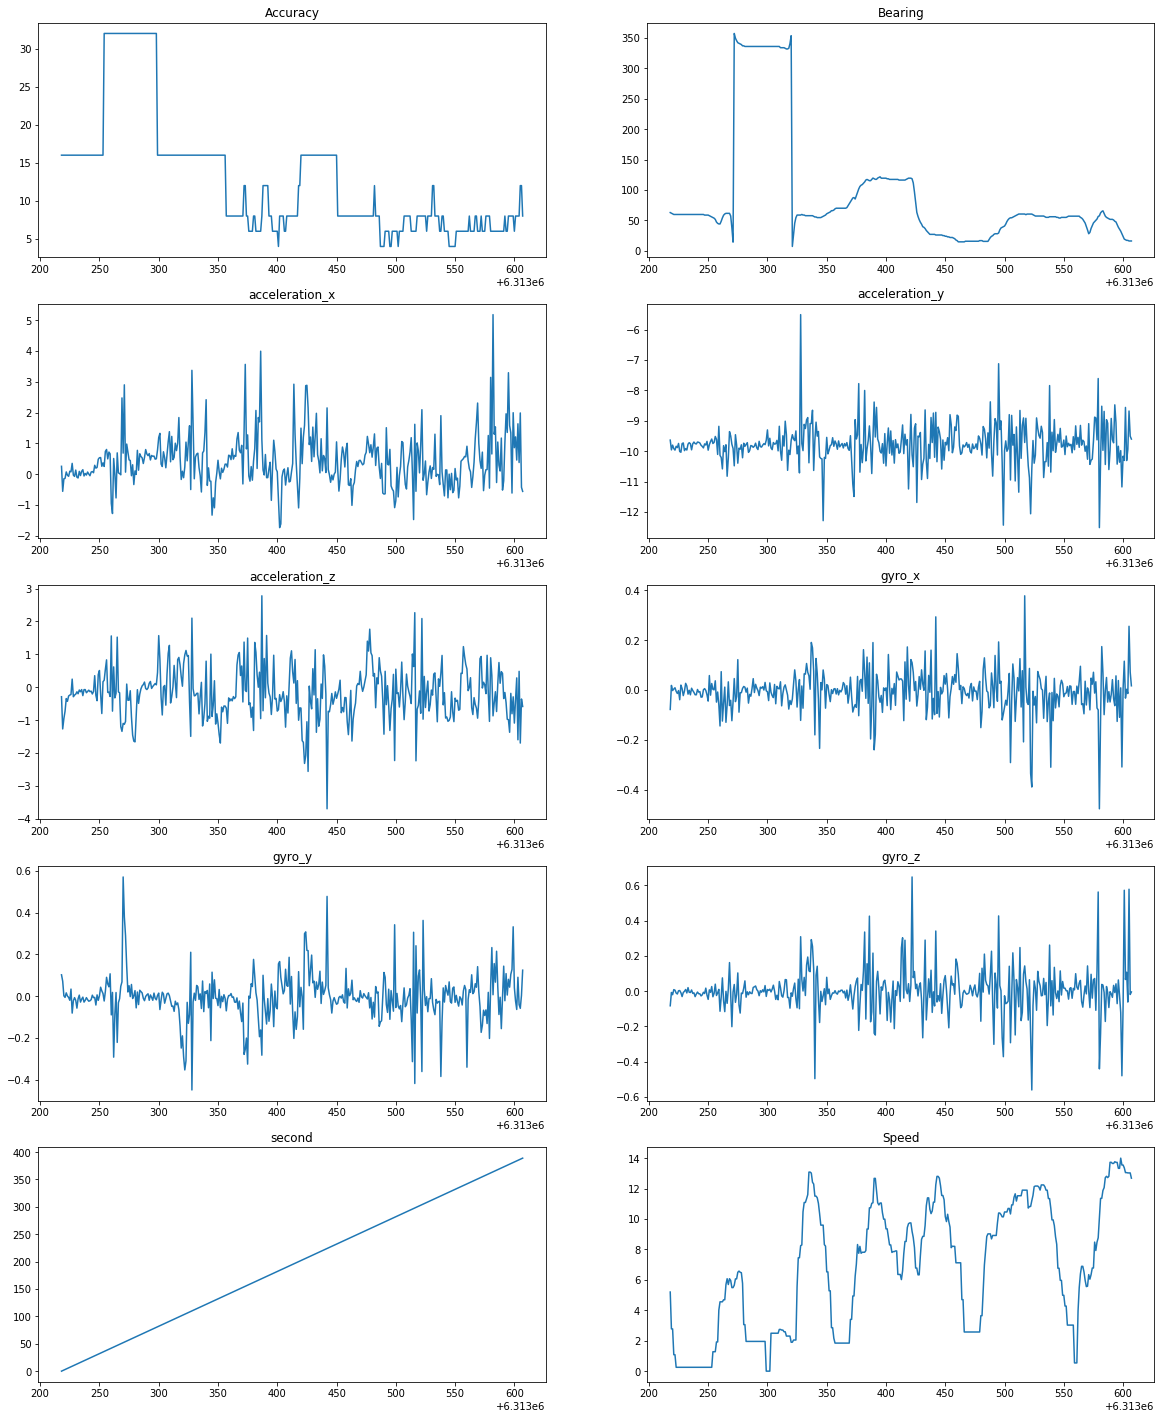

In [128]:
plotID = random.choice(df['bookingID'].unique())
while non_consecutive_bookings[plotID]:
    plotID = random.choice(df['bookingID'].unique())
    
plotColumns = ['Accuracy','Bearing','acceleration_x','acceleration_y','acceleration_z',
               'gyro_x','gyro_y','gyro_z','second','Speed']
       
fig = plt.figure(figsize=(20,25))

for i in range(len(plotColumns)):
    ax = fig.add_subplot(5,2,i+1)
    ax.title.set_text(plotColumns[i])
    df.loc[df['bookingID']==plotID,plotColumns[i]].plot()

We see that the non-GPS sensors are far noisier than the GPS ones.

We will smoothen the bookingID with consecutive seconds by using a simple moving average window (for simplicity), we will use the value of non-consecutive data similar to the beginning of the trip. To measure the effects of the smoothing, we will compare the performance with the non-smoothed ones.

The simple moving average window is described as follows:

Let's say a raw sensor value $x_t$ at time $t$ and we want to smooth it as $\bar{x}_t$. We will assign a smoothed value $\bar{x}_t$ as the average of its raw value and $l-1$ previous raw values. However, we will only use available data for the first $l-1$ values.

$\bar{x}_t = \frac{1}{l} \sum_{i=0}^{l-1} x_{t-i}$

Example: Bearing value at t=0 until t=3: \{ 300, 320, 0, 20\} and $l=3$, we will get the smoothed values:

$\bar{x}_0 = \frac{1}{3}(300+300+300) = 300$

$\bar{x}_1 = \frac{1}{3}(300+300+320) = 306.66$

$\bar{x}_2 = \frac{1}{3}(300+320+0) = 206.66$

$\bar{x}_3 = \frac{1}{3}(320+0+20) = 106.66$

Wait something's wrong for t=2 and t=3, shouldn't it be closer to $\approx$ 360-ish? Well, this is a well known problem of averaging degrees, we will use [Mean Angle](https://rosettacode.org/wiki/Averages/Mean_angle) --> Only applies to Bearing, other sensors are safe!

$\bar{x}_t = atan2(\frac{1}{l}.\sum_{i=0}^{l-1} sin(x_{t-i}),\frac{1}{l}.\sum_{i=0}^{l-1} cos(x_{t-i}))$

Much better! Let's define the function!

**Note**: Unlike the Bearings, we can apply this moving window average simply to the other sensors. We define this as a new function smoothMWA.


In [129]:
def smoothMWA(rows, isBearing=False, l=3):
    #To make sure we did not use any values that are not are the start of the trip nor the non-consecutive seconds.
    a= 1*~ (startTrip | non_consecutive_rows )
    shift = rows
    rowsShift = rows
    for i in range(l-1):
        shift = pd.Series([0]).append(shift, ignore_index=True)[:-1] 
        dupRowsA = (a*shift)+((1-a) * rows)
        rowsShift = pd.concat([rowsShift,dupRowsA],axis=1)
        a = a * pd.Series([0]).append(a, ignore_index=True)[:-1] 

    if isBearing:
        rowsShift = rowsShift - 180
        rowsShift = np.radians(rowsShift)
        sina = np.sin(rowsShift).mean(axis=1)
        cosa = np.cos(rowsShift).mean(axis=1)
        rowsShift = np.degrees(np.arctan2(sina,cosa))
        return rowsShift
    else:
        return (rowsShift/l).sum(axis=1)

We name the smoothed data as sdf. For default value, we use the length of 3.

In [130]:
smoothingColumns = ['Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z','Speed']

sdf = df[['bookingID','Accuracy','second']]
for column in smoothingColumns:
    if column=='Bearing':
        sdf[column] = smoothMWA(df[column],True,l=3)
    else:
        sdf[column] = smoothMWA(df[column],l=3)

D:\Env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
D:\Env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Let's check the smoothed values and compare it side by side with the unsmoothed ones.

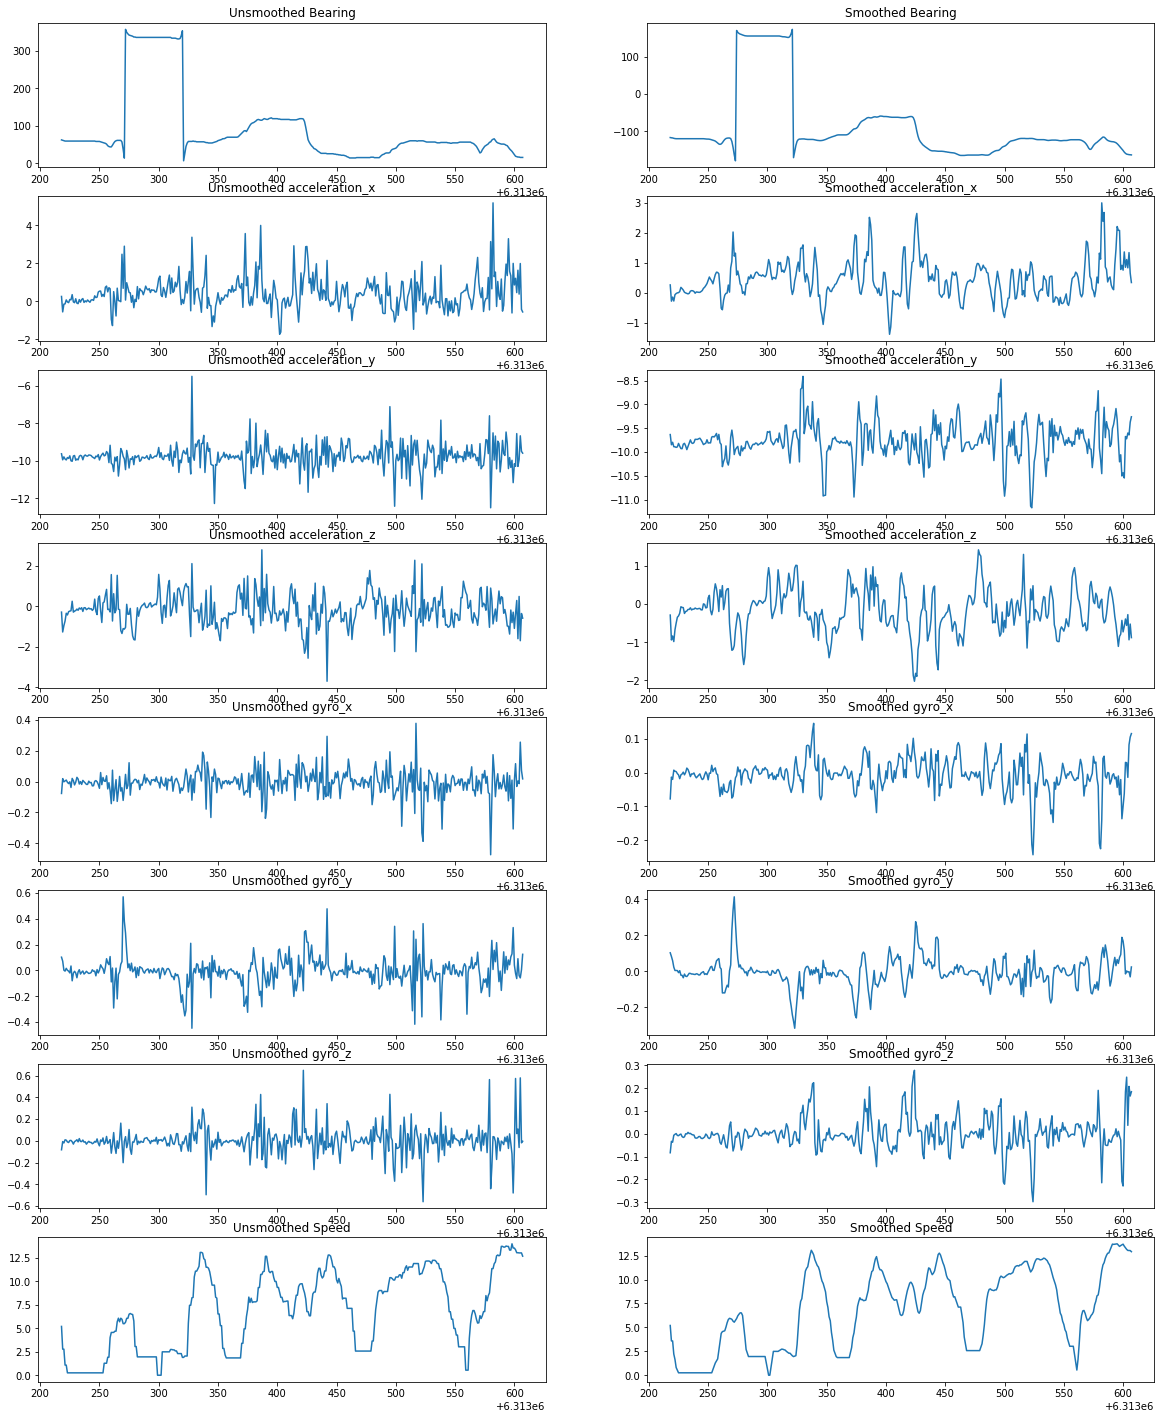

In [131]:
fig = plt.figure(figsize=(20,25))
plotColumns = ['Bearing','acceleration_x','acceleration_y','acceleration_z',
               'gyro_x','gyro_y','gyro_z','Speed']

for i in range(len(plotColumns)):
    ax = fig.add_subplot(8,2,(i*2)+1)
    ax.title.set_text("Unsmoothed "+plotColumns[i])
    df.loc[df['bookingID']==plotID,plotColumns[i]].plot()
    
    ax = fig.add_subplot(8,2,(i*2)+2)
    ax.title.set_text("Smoothed "+plotColumns[i])
    sdf.loc[sdf['bookingID']==plotID,plotColumns[i]].plot()

Do not worry, we will compare the quality of the performance later.

-------------------------

<a id='new-features'></a>
# 3. Introducing New Features

Based on the sensors' characteristics, we can introduce new features, such as
- acceleration resultant (from acceleration x,y,z)
- speed change (from speed)
- speed/integrated acceleration (from acceleration resultant)
- gyroscope resultant (from gyroscope x,y,z)
- bearing change (from bearing)

**NOTE that: the change and integration cannot be inferred non-consecutive seconds.**

We group the acceleration resultant and the gyroscope resultant as one function, since they are similar. It also applies for the speed and bearing change. But, we will break them down one by one after the functions.

For break-down-examples here, we will use it for unsmoothed data first, then the smoothed data using function.

In [132]:
def ComputeResultant(data_xyz,isAcc=False):
    data_r = np.sqrt(np.power(data_xyz.iloc[:,0],2)
                          +np.power(data_xyz.iloc[:,1],2)
                          +np.power(data_xyz.iloc[:,2],2))

    if isAcc:
        data_r = np.abs(data_r-9.8)
    
    return data_r

def ComputeChange(data, isBearing):
    #calculating the change of speed between time step, for bearing: angularSpeed
    series_data1 = data.append(pd.Series([0]), ignore_index=True)
    series_data2 = pd.Series([0]).append(data, ignore_index=True)
    d_data = (series_data1 - series_data2)[:-1]

    #marking the beginning of the trip
    d_data[startTrip|non_consecutive_rows] = 0
    
    if isBearing:
        #Negative change is equal to the positive change in degree
        d_data = np.abs(d_data)

        #The bearing change >180 must be re-computed as the angle change > 180 is equal to angle change <=180.
        ## This is caused by [0...360] range
        d_data.loc[d_data>180] = 360 - d_data[d_data>180]
    return d_data

def IntegrateAcc(acc_r):
    #integrating the acceleration for each time step, duplicates and appends a 0 value
    series_acc1 = acc_r.append(pd.Series([0]), ignore_index=True)
    series_acc2 = pd.Series([0]).append(acc_r, ignore_index=True)

    #Setting the beginning of the trip is always 0
    startTripS = startTrip.append(pd.Series([True]), ignore_index=True)
    series_acc2[startTripS|non_consecutive_rows] = 0

    #Computing the integration
    i_acc = ((series_acc1 + series_acc2)/2)[:-1]

    return i_acc

## 3.1. Acceleration Resultant

Because the accelerometer measures the acceleration in 3 axes, we compute its resultant by 

$a_r = \sqrt{a_x^2+a_y^2+a_z^2}$

In [133]:
df['acc_r'] = np.sqrt(np.power(df['acceleration_x'],2)
                      +np.power(df['acceleration_y'],2)
                      +np.power(df['acceleration_z'],2))

In [134]:
df[['bookingID','acc_r']].head()

,bookingID,acc_r
0,0,10.176551
1,0,10.059553
2,0,9.503762
3,0,9.830320
4,0,9.967466


The accelerometer resultant is however seemingly interesting. It might contain the gravity speed (9.8 m/s2). Let's check the MEAN/MAX/MIN.

In [135]:
df['acc_r'].describe()

count    1.613556e+07
mean     9.893247e+00
std      1.268255e+00
min      5.074228e-03
25%      9.548978e+00
50%      9.817841e+00
75%      1.013325e+01
max      1.151522e+02
Name: acc_r, dtype: float64

It is clear that most of the data is around the $\approx 9.8 m/s^2$, we will have to substract them by 9.8 and compute their absolute value.


In [136]:
df['acc_r'] = np.abs(df['acc_r']-9.8)

## 3.2. Speed Change

Then, we compute the $v_t - v_{t-1}$ for each time step in the trip data as d_speed

**Issue for data transformation:** in the beginning and non-consecutive seconds of each trip, the speed change should 0 (assuming the beginning of the trip is always safe). Thus, we need to mark those rows as 0.

In [137]:
#Data Transformation of speed change

#calculating the change of speed between time step
series_speed1 = df['Speed'].append(pd.Series([0]), ignore_index=True)
series_speed2 = pd.Series([0]).append(df['Speed'], ignore_index=True)
df['d_Speed'] = (series_speed1 - series_speed2)[:-1]

#marking the beginning of the trip
df.loc[startTrip|non_consecutive_rows,'d_Speed'] = 0

## 3.3. Speed/Integrated Acceleration

Other than the speed alone, we can compute the speed from the accelerometer (by trapezoidal integration, don't worry, it is simple).

$v_t (acc) =  \frac{\Delta t}{2} (acc_{r,t} + acc_{r,t-1})$

In [138]:
#integrating the acceleration for each time step, duplicates and appends a 0 value
series_acc1 = df['acc_r'].append(pd.Series([0]), ignore_index=True)
series_acc2 = pd.Series([0]).append(df['acc_r'], ignore_index=True)

#Setting the beginning of the trip is always 0
startTrip1 = startTrip.append(pd.Series([True]), ignore_index=True)
series_acc2[startTrip1|non_consecutive_rows] = 0

#Computing the integration
df['i_acc'] = ((series_acc1 + series_acc2)/2)[:-1]

## 3.4. Gyroscope Resultant

Similar to the accelerometer, the gyroscope measures the orientation change in 3-axis. Thus, we would like to use its resultant by.

$\omega_r = \sqrt{\omega_x^2+\omega_y^2+\omega_z^2}$


In [139]:
df['gyro_r'] = np.sqrt(np.power(df['gyro_x'],2)
                      +np.power(df['gyro_y'],2)
                      +np.power(df['gyro_z'],2))

## 3.5. Bearing Change

Then, we compute the change of the orientation from the GPS of each time step in a trip by the GPS Bearing variable.

In [140]:
#Computing the change is similar to the speed change, 
series_orie1 = df['Bearing'].append(pd.Series([0]), ignore_index=True)
series_orie2 = pd.Series([0]).append(df['Bearing'], ignore_index=True)
df['d_Bearing'] = (series_orie1 - series_orie2)[:-1]

#marking the beginning of the trip
df.loc[startTrip|non_consecutive_rows,'d_Bearing'] = 0

#Negative change is equal to the positive change in degree
df['d_Bearing'] = np.abs(df['d_Bearing'])

#The bearing change >180 must be re-computed as the angle change > 180 is equal to angle change <=180.
## This is caused by [0...360] range
df.loc[df['d_Bearing']>180,'d_Bearing'] = 360 - df.loc[df['d_Bearing']>180,'d_Bearing']

Performing creating new features using the smoothed data.

In [141]:
sdf.loc[:,'acc_r'] = ComputeResultant(sdf[['acceleration_x','acceleration_y','acceleration_z']],isAcc=True)
sdf.loc[:,'d_Speed'] = ComputeChange(sdf['Speed'],isBearing=False)
sdf.loc[:,'i_acc'] = IntegrateAcc(sdf['acc_r'])
sdf.loc[:,'gyro_r'] = ComputeResultant(sdf[['gyro_x','gyro_y','gyro_z']],isAcc=False)
sdf.loc[:,'d_Bearing'] = ComputeChange(sdf['Bearing'],isBearing=True)

-----------------------------------
<a id='eda'></a>
# 4. Exploratory Data Analysis

Now, for each features, we will display the MAX aggregate as sample. Why? Because we assume these things:
- High speed driving
- sudden brake (high deceleration)
- sudden acceleration (high acceleration)
- high speed turning (high orientation change)

We sample them by the smoothed data.

But, it is also possible that other aggregate function help too.

In [142]:
max_features = df.groupby(['bookingID'], as_index=False).max()
max_features_labeled = pd.merge(max_features,labelc,on="bookingID")

In [143]:
max_features_labeled.columns

Index(['bookingID', 'Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed',
       'acc_r', 'd_Speed', 'i_acc', 'gyro_r', 'd_Bearing', 'label'],
      dtype='object')

In [144]:
plotColumns = ['Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed',
       'acc_r', 'd_Speed', 'i_acc', 'gyro_r', 'd_Bearing']

D:\Env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


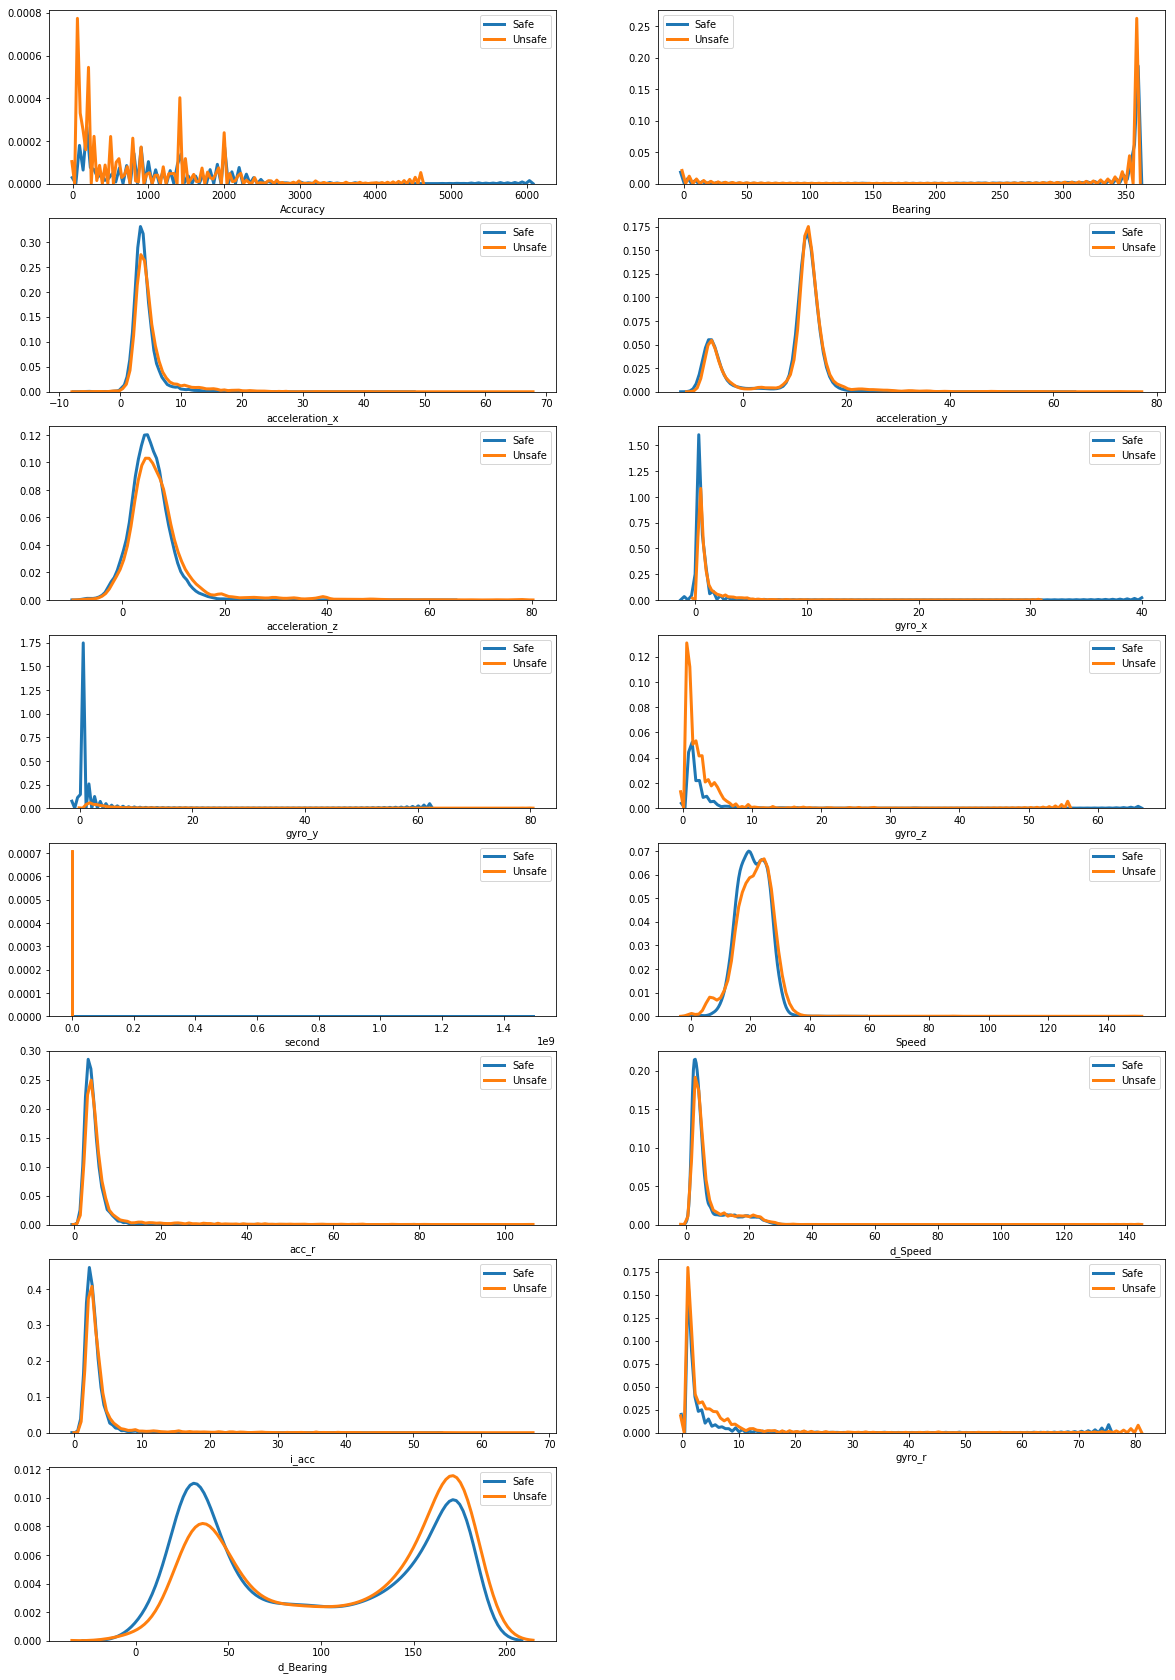

In [145]:
fig = plt.figure(figsize=(20,30))

for i in range(len(plotColumns)):
    ax = fig.add_subplot(8,2,i+1)
    max_features_safe   = max_features_labeled[max_features_labeled['label']==0][plotColumns[i]]
    max_features_unsafe = max_features_labeled[max_features_labeled['label']==1][plotColumns[i]]
    sns.distplot(max_features_safe, hist = False, kde = True, kde_kws = {'linewidth': 3}, label = "Safe")
    sns.distplot(max_features_unsafe, hist = False, kde = True, kde_kws = {'linewidth': 3}, label = "Unsafe")

It seems that the features that can distinguish the safe/unsafe driving is d_Bearing. Lower change of bearing is more likely to be safe instead of higher change of bearing. While the weird one is the second (yes, because it has dirty data, which has maximum value of $1.49\times 10^9$).

Meanwhile, let's re-check the seconds again. We will redefine the trip length by the MAX - MIN of seconds.

In [146]:
trip_length = sdf[['bookingID','second']].groupby(['bookingID']).max() - sdf[['bookingID','second']].groupby(['bookingID']).min() 

trip_length.describe()

,second
count,2.000000e+04
mean,1.995713e+05
std,1.373137e+07
min,1.190000e+02
25%,5.540000e+02
50%,8.540000e+02
75%,1.221000e+03
max,1.495797e+09


Frankly speaking, this $1.49\times 10^9$ value is very nasty. Let's find the culprit's bookingID, remove them, and find the true distribution of second.

In [147]:
trip_length.sort_values(by='second',ascending=False)[:10]

,second
bookingID,
1503238553722,1.495797e+09
1460288880770,6.193166e+08
858993459333,6.193160e+08
1434519076976,6.193156e+08
1108101562401,6.193155e+08
438086664371,8.235000e+03
532575944853,7.355000e+03
446676598869,5.988000e+03
1374389534819,4.499000e+03


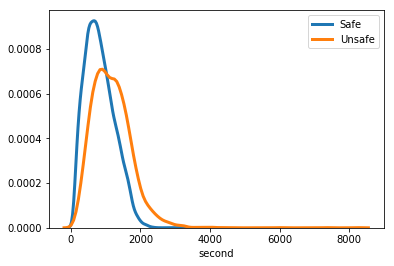

In [148]:
trip_length_x = trip_length.sort_values(by='second',ascending=False)[5:]
trip_length_labeled = pd.merge(trip_length_x,labelc,on="bookingID")

trip_length_safe   = trip_length_labeled[trip_length_labeled['label']==0]['second']
trip_length_unsafe = trip_length_labeled[trip_length_labeled['label']==1]['second']
sns.distplot(trip_length_safe, hist = False, kde = True, kde_kws = {'linewidth': 3}, label = "Safe")
sns.distplot(trip_length_unsafe, hist = False, kde = True, kde_kws = {'linewidth': 3}, label = "Unsafe")

Interesting, the longer trip tends to have less safe driving. Let's keep this in mind.

----------------------------
<a id='exp'></a>
# 5. Experiments & Feature Selection

We suppose the problem of the safe/unsafe driving detection by taking the characteristics of the trip given its features, including the original (except: bookingID) and derived ones. These characteristics are provided by its statistical information such as MAX, MIN, MEAN, VAR. And another exception for the 'second' feature, we use the trip_length as the additional feature (omitting the original 'second' feature).

We evaluate the experiments on:
- Windows 10 64-bit
- i7-4790 CPU @ 3.60 GHz
- 16 GB RAM
- Python 3.6.8

Let's recheck our features again.

In [149]:
df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acc_r,d_Speed,i_acc,gyro_r,d_Bearing
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0.376551,0.000000,0.188275,0.118788,0.0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0.259553,-3.214536,0.318052,0.101508,0.0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0.296238,0.000000,0.277895,0.046282,0.0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0.030320,0.000000,0.163279,0.034511,0.0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0.167466,0.000000,0.098893,0.053095,0.0


In [150]:
sdf.head()

,bookingID,Accuracy,second,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,Speed,acc_r,d_Speed,i_acc,gyro_r,d_Bearing
0,0,12.0,0.0,-36.701706,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,3.442991,0.376551,0.000000,0.188275,0.118788,0.0
1,0,8.0,1.0,-36.701706,0.636974,-9.870880,-2.030950,-0.036810,-0.083930,0.052369,1.299966,0.297761,-2.143024,0.337156,0.105554,0.0
2,0,8.0,2.0,-36.701706,-0.113897,-9.682614,-1.754458,-0.030767,-0.068522,0.043103,1.299966,0.040941,0.000000,0.169351,0.086602,0.0
3,0,8.0,3.0,-36.701706,-0.858836,-9.551471,-1.703117,-0.032823,-0.035493,0.010942,0.228454,0.059938,-1.071512,0.050439,0.049566,0.0
4,0,8.0,4.0,-36.701706,-1.240352,-9.557452,-1.483000,-0.021892,-0.024603,0.003846,0.228454,0.048966,0.000000,0.054452,0.033156,0.0


In [151]:
sdf.shape

(16135561, 16)

In [152]:
def aggregateAll(features,trip_length):
    f_nosec = features.drop(columns=['second'])
    f_agg_mean= f_nosec.groupby(['bookingID'], as_index=False).mean()
    f_agg_max = f_nosec.groupby(['bookingID'], as_index=False).max()
    f_agg_min = f_nosec.groupby(['bookingID'], as_index=False).min()
    f_agg_var = f_nosec.groupby(['bookingID'], as_index=False).var()

    #renaming the columns
    col_mean = ['bookingID']
    col_max = ['bookingID']
    col_min = ['bookingID']
    col_var = ['bookingID']

    colnames_default = f_nosec.columns
    for colname in colnames_default:
        if colname=='bookingID':
            continue
        col_mean.append(colname+"_mean")
        col_max.append(colname+"_max")
        col_min.append(colname+"_min")
        col_var.append(colname+"_var")

    f_agg_mean.columns= col_mean
    f_agg_max.columns = col_max
    f_agg_min.columns = col_min
    f_agg_var.columns = col_var

    #joining all the aggregations
    f_agg = pd.merge(f_agg_mean,f_agg_max,on="bookingID")
    f_agg = pd.merge(f_agg,f_agg_min,on="bookingID")
    f_agg = pd.merge(f_agg,f_agg_var,on="bookingID")
    f_agg = pd.merge(f_agg,trip_length,on="bookingID")
    
    return f_agg

In [153]:
df_agg  = aggregateAll(df,trip_length)
sdf_agg = aggregateAll(sdf,trip_length)

In [154]:
df_agg.shape

(20000, 58)

In [155]:
df_agg.head()

,bookingID,Accuracy_mean,Bearing_mean,acceleration_x_mean,acceleration_y_mean,acceleration_z_mean,gyro_x_mean,gyro_y_mean,gyro_z_mean,Speed_mean,...,gyro_x_var,gyro_y_var,gyro_z_var,Speed_var,acc_r_var,d_Speed_var,i_acc_var,gyro_r_var,d_Bearing_var,second
0,0,10.165339,176.526099,-0.711264,-9.613822,-1.619658,0.003328,-0.006118,-0.004188,8.995818,...,0.004350,0.010045,0.004056,51.819906,0.216096,0.780974,0.130092,0.008352,10.965865,1589.0
1,1,3.718763,124.198590,-0.525406,9.532086,-2.198999,-0.002467,-0.007540,0.000405,7.896864,...,0.000770,0.008409,0.001145,49.577975,0.137018,3.397650,0.082989,0.006001,249.807816,1034.0
2,2,3.930626,173.794872,0.306786,9.843183,0.139347,0.006458,-0.012861,0.002597,3.157213,...,0.002906,0.013764,0.001312,8.397027,0.191973,0.735884,0.128056,0.008654,385.330267,825.0
3,4,10.000000,151.807013,-0.365117,-9.406439,-2.613639,-0.022884,0.023232,-0.000376,6.150996,...,0.001793,0.012671,0.004346,31.314103,0.282001,0.556470,0.164203,0.008010,19.365560,1094.0
4,6,4.586721,197.812785,0.490616,9.538043,2.355059,0.003877,0.000436,0.002930,4.628921,...,0.003044,0.011409,0.003299,28.247568,0.193572,0.452575,0.121646,0.009743,45.341820,1094.0


In [156]:
sdf_agg.head()

,bookingID,Accuracy_mean,Bearing_mean,acceleration_x_mean,acceleration_y_mean,acceleration_z_mean,gyro_x_mean,gyro_y_mean,gyro_z_mean,Speed_mean,...,gyro_x_var,gyro_y_var,gyro_z_var,Speed_var,acc_r_var,d_Speed_var,i_acc_var,gyro_r_var,d_Bearing_var,second
0,0,10.165339,-3.260979,-0.707563,-9.614459,-1.619822,0.003250,-0.006242,-0.004037,8.981747,...,0.001365,0.005058,0.001431,51.444492,0.067246,0.275874,0.054069,0.003699,8.849185,1589.0
1,1,3.718763,-53.859973,-0.525698,9.530254,-2.199939,-0.002430,-0.007209,0.000249,7.905173,...,0.000246,0.006146,0.000579,48.188831,0.045168,0.742876,0.034680,0.004638,26.596957,1034.0
2,2,3.930626,-4.126680,0.305534,9.843854,0.123098,0.006782,-0.012686,0.002915,3.175903,...,0.000955,0.010934,0.000447,8.178130,0.048288,0.299040,0.039769,0.005825,229.237922,825.0
3,4,10.000000,-28.078146,-0.365511,-9.406432,-2.612577,-0.022903,0.023156,-0.000388,6.153693,...,0.000585,0.007941,0.001774,31.017247,0.107184,0.332550,0.090734,0.004435,16.670928,1094.0
4,6,4.586721,18.638723,0.490173,9.538664,2.353099,0.003869,0.000922,0.003038,4.634365,...,0.001025,0.007753,0.001192,28.008513,0.068210,0.293997,0.054950,0.006063,22.725960,1094.0


For the classifiers, we use the RandomForest and XGBoost as benchmarks.
First, we will optimize the parameters using hyperopt [http://hyperopt.github.io/hyperopt/] with k=5 cross validation (to shorten the time) to use the models with the most optimal parameters. In the optimization, we use the smoothed data, to reduce the experimentation time.

In [176]:
#defined the functions a little bit dirty, because have just learned to use the library (ehem, running out of time)

def rf_objective(args):
    params = {
        'n_estimators': int(args['n_estimators']), 
        'max_depth': int(args['max_depth'])
    }
    rf_clf = RandomForestClassifier(**params)
    score = cross_val_score(rf_clf, train_data, train_label, scoring='roc_auc', cv=KFold(n_splits=5)).mean()
    print("ROC-AUC {:.3f} params {}".format(score, args))

    return {'loss':1-score, 'status': STATUS_OK }


def xgb_objective(args):
    params = {
        'gamma': "{:.3f}".format(args['gamma']),
        'colsample_bytree': '{:.3f}'.format(args['colsample_bytree']),
        'n_estimators': int(args['n_estimators']),
        'max_depth': int(args['max_depth'])
    }
    xgb_clf = XGBClassifier(**params)    
    score = cross_val_score(xgb_clf, train_data, train_label, scoring='roc_auc', cv=KFold(n_splits=5)).mean()
    print("ROC-AUC {:.3f} params {}".format(score, params))

    return {'loss':1-score, 'status': STATUS_OK }

## Using Smoothed Data

In [178]:
train_data = sdf_agg
train_label = labelc['label']

rf_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
    'max_depth': hp.quniform('max_depth', 1, 10, 1)
}

trials = Trials()
best = fmin(fn=rf_objective,
            space=rf_space,
            algo=tpe.suggest,
            max_evals=20)

print("RF best parameters {}".format(best))

xgb_space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
    'max_depth': hp.quniform('max_depth', 1, 10, 1)
}

trials = Trials()
best = fmin(fn=xgb_objective,
            space=xgb_space,
            algo=tpe.suggest,
            max_evals=20)

print("XGB best parameters {}".format(best))

ROC-AUC 0.719 params {'max_depth': 9.0, 'n_estimators': 600.0}                                                         
ROC-AUC 0.697 params {'max_depth': 2.0, 'n_estimators': 500.0}                                                         
ROC-AUC 0.719 params {'max_depth': 9.0, 'n_estimators': 200.0}                                                         
ROC-AUC 0.718 params {'max_depth': 8.0, 'n_estimators': 700.0}                                                         
ROC-AUC 0.697 params {'max_depth': 2.0, 'n_estimators': 300.0}                                                         
ROC-AUC 0.709 params {'max_depth': 5.0, 'n_estimators': 500.0}                                                         
ROC-AUC 0.715 params {'max_depth': 7.0, 'n_estimators': 1000.0}                                                        
ROC-AUC 0.702 params {'max_depth': 3.0, 'n_estimators': 400.0}                                                         
ROC-AUC 0.718 params {'max_depth': 9.0, 

## Using Unsmoothed Data

In [ ]:
train_data = df_agg
train_label = labelc['label']

rf_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
    'max_depth': hp.quniform('max_depth', 1, 10, 1)
}

trials = Trials()
best = fmin(fn=rf_objective,
            space=rf_space,
            algo=tpe.suggest,
            max_evals=20)

print("RF best parameters {}".format(best))

xgb_space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
    'max_depth': hp.quniform('max_depth', 1, 10, 1)
}

trials = Trials()
best = fmin(fn=xgb_objective,
            space=xgb_space,
            algo=tpe.suggest,
            max_evals=20)

print("XGB best parameters {}".format(best))

ROC-AUC 0.717 params {'max_depth': 9.0, 'n_estimators': 500.0}                                                         
ROC-AUC 0.712 params {'max_depth': 6.0, 'n_estimators': 800.0}                                                         
ROC-AUC 0.714 params {'max_depth': 7.0, 'n_estimators': 400.0}                                                         
ROC-AUC 0.694 params {'max_depth': 2.0, 'n_estimators': 600.0}                                                         
ROC-AUC 0.708 params {'max_depth': 5.0, 'n_estimators': 800.0}                                                         
ROC-AUC 0.695 params {'max_depth': 2.0, 'n_estimators': 400.0}                                                         
ROC-AUC 0.716 params {'max_depth': 8.0, 'n_estimators': 800.0}                                                         
ROC-AUC 0.701 params {'max_depth': 3.0, 'n_estimators': 500.0}                                                         
ROC-AUC 0.705 params {'max_depth': 4.0, 

Then, we get ... as RandomForest's best parameters and ... as XGBoost. Next, given the optimal parameters, we will measure the accuracy, AUC, and running time for the unsmoothed data. Next, we try to pick some important features based on each classifier.

In [179]:
def kfoldValidation(features, label, model, k):
    
    #just in case someone forgets
    if "bookingID" in features.columns:
        features = features.drop(columns=['bookingID'])
    
    sum_acc = 0
    sum_auc = 0
    sum_avg_time = 0
    kf = KFold(n_splits=k)
    
    for train, val in kf.split(features):
        time_start = time.time()
        
        train_data = np.array(features)[train]
        train_label = np.array(label)[train]
        val_data = np.array(features)[val]
        val_label = np.array(label)[val]
        
        model.fit(train_data,train_label)

        val_pred  = model.predict_proba(val_data)[:,1]

        sum_acc = sum_acc + accuracy_score(val_label, 1 * (val_pred >0.5) )
        sum_auc = sum_auc + roc_auc_score(val_label, val_pred)
        
        elapsed_time = time.time() - time_start
        sum_avg_time = sum_avg_time + (elapsed_time/(train_data.shape[0]))

    #we also measure the average time of single instance prediction in ms
    return sum_acc/k, sum_auc/k, (sum_avg_time/k)*1000

We will observe the unsmoothed data first.

In [98]:
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=2,random_state=0)
acc, auc, rtime = kfoldValidation(df_agg,labelc["label"],rf_clf,10)
print("accuracy: "+str(acc)+" AUC: "+str(auc)+" Running time (ms)): " +str(rtime))

xgb_clf = XGBClassifier(n_jobs=-1)
acc, auc, rtime = kfoldValidation(df_agg,labelc["label"],xgb_clf,10)
print("accuracy: "+str(acc)+" AUC: "+str(auc)+" Running time (ms): " +str(rtime))

accuracy: 0.7635500000000001 AUC: 0.694509817330956 Running time (ms)): 0.5420095523198446
accuracy: 0.7806 AUC: 0.7335337500996556 Running time (ms): 0.08964692884021334


Next, let's try to check the feature importance for each classifier.

In [96]:
def plotFeatureImportance(clf, ax, columnNames, strModelName):
    indices = np.argsort(clf.feature_importances_)
    ax.title.set_text('Feature Importances - '+strModelName)
    ax.barh(range(len(indices)), clf.feature_importances_[indices], color='b', align='center')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([columnNames[i] for i in indices])
    ax.set_xlabel('Relative Importance')

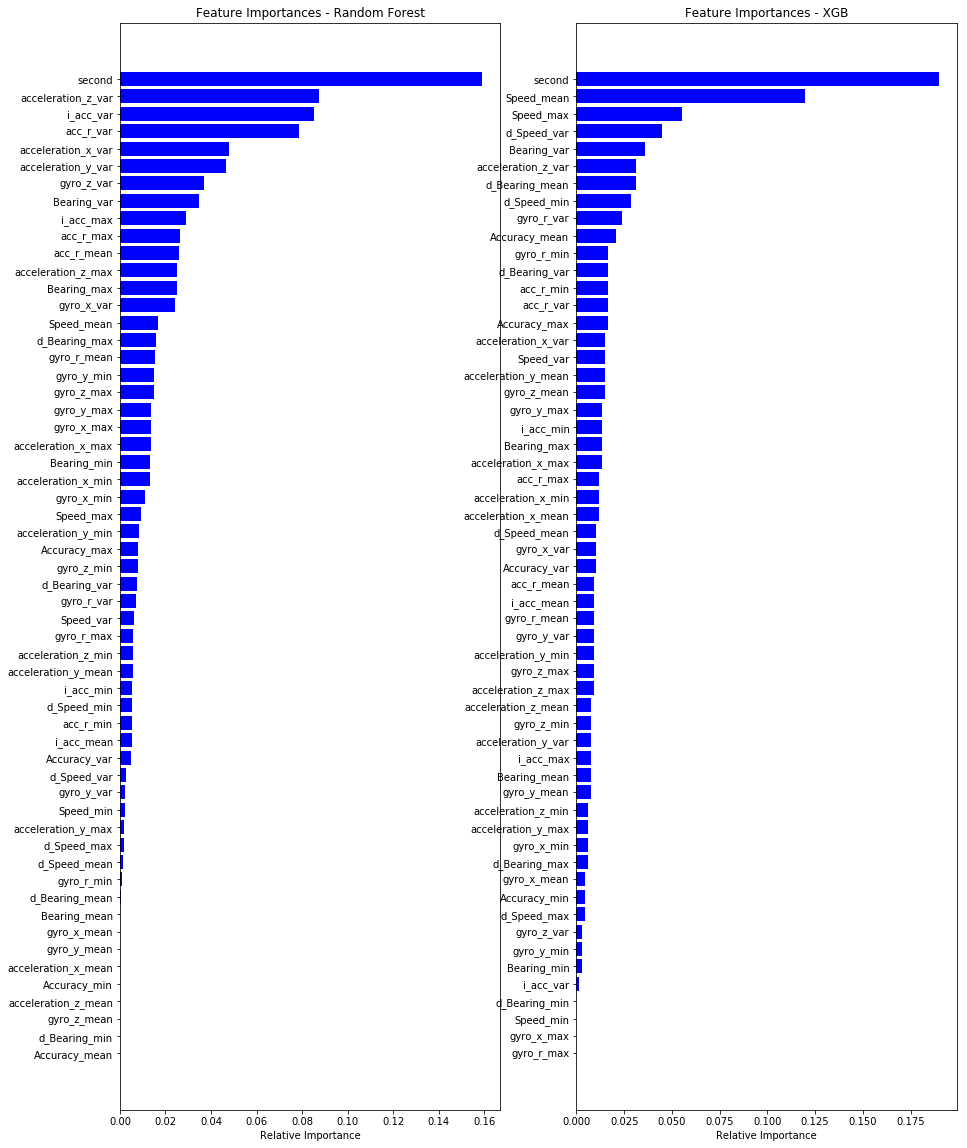

In [97]:
df_train = df_agg.drop(columns=['bookingID'])

rf_clf = RandomForestClassifier(n_estimators=500, max_depth=2,random_state=0)
rf_clf.fit(df_train,labelc["label"])

xgb_clf = XGBClassifier(n_jobs=-1)
xgb_clf.fit(df_train,labelc["label"])

fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(1,2,1)
plotFeatureImportance(rf_clf,ax,df_train.columns,"Random Forest")
ax = fig.add_subplot(1,2,2)
plotFeatureImportance(xgb_clf,ax,df_train.columns,"XGB")

plt.show()

Then, let's check the performance on smoothed data. After that, checking the feature importance.

In [99]:
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=2,random_state=0)
acc, auc, rtime = kfoldValidation(sdf_agg,labelc["label"],rf_clf,10)
print("accuracy: "+str(acc)+" AUC: "+str(auc)+" Running time (ms): " +str(rtime))

xgb_clf = XGBClassifier(n_jobs=-1)
acc, auc, rtime = kfoldValidation(sdf_agg,labelc["label"],xgb_clf,10)
print("accuracy: "+str(acc)+" AUC: "+str(auc)+" Running time (ms): " +str(rtime))

accuracy: 0.7642000000000001 AUC: 0.6973781789368148 Running time (ms): 0.5673838893572489
accuracy: 0.7804000000000001 AUC: 0.7349872918920344 Running time (ms): 0.0725751558939616


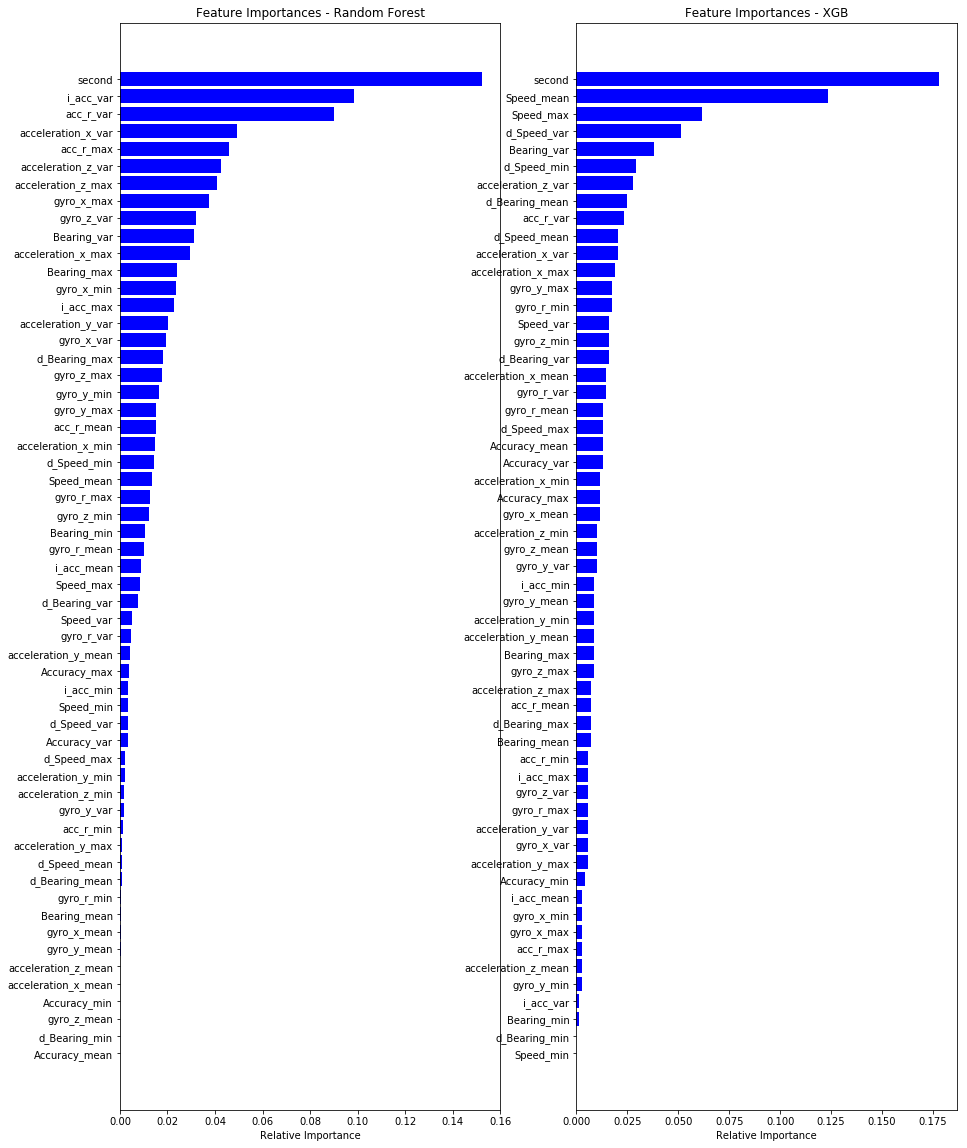

In [101]:
sdf_train = sdf_agg.drop(columns=['bookingID'])

rf_clf = RandomForestClassifier(n_estimators=500, max_depth=2,random_state=0)
rf_clf.fit(sdf_train,labelc["label"])

xgb_clf = XGBClassifier(n_jobs=-1)
xgb_clf.fit(sdf_train,labelc["label"])

fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(1,2,1)
plotFeatureImportance(rf_clf,ax,sdf_train.columns,"Random Forest")
ax = fig.add_subplot(1,2,2)
plotFeatureImportance(xgb_clf,ax,sdf_train.columns,"XGB")

plt.show()

Well it was improved by 0.001 and they are not very different from the unsmoothed version. While it is not very astonishing, this is a good sign. Let's try something else by picking important features from both classifiers as Regularization. Note: we will exclude features from the 3-axes (any feature x-y-z related, only taking the resultants). We will use 0.05 as threshold value.

Thus, we will have: second, i_acc_var, acc_r_var, Speed_mean, Speed_max, d_Speed_var

In [108]:
pickColumns = ['second', 'i_acc_var', 'acc_r_var', 'Speed_mean', 'Speed_max', 'd_Speed_var']
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=2,random_state=0)
acc,auc,rtime = kfoldValidation(df_agg[pickColumns],labelc["label"],rf_clf,10)
print("RF on unsmoothed: accuracy: "+str(acc)+" AUC: "+str(auc)+" Running time (ms): " +str(rtime))

xgb_clf = XGBClassifier(n_jobs=-1)
acc,auc,rtime = kfoldValidation(df_agg[pickColumns],labelc["label"],xgb_clf,10)
print("XGBoost on unsmoothed: accuracy: "+str(acc)+" AUC: "+str(auc)+" Running time (ms): " +str(rtime))

rf_clf = RandomForestClassifier(n_estimators=500, max_depth=2,random_state=0)
acc,auc,rtime = kfoldValidation(sdf_agg[pickColumns],labelc["label"],rf_clf,10)
print("RF on smoothed: accuracy: "+str(acc)+" AUC: "+str(auc)+" Running time (ms): " +str(rtime))

xgb_clf = XGBClassifier(n_jobs=-1)
acc,auc,rtime = kfoldValidation(sdf_agg[pickColumns],labelc["label"],xgb_clf,10)
print("XGB on smoothed: accuracy: "+str(acc)+" AUC: "+str(auc)+" Running time (ms): " +str(rtime))

RF on unsmoothed: accuracy: 0.76275 AUC: 0.6990860070357243 Running time (ms): 0.2055729627609253
XGBoost on unsmoothed: accuracy: 0.7795500000000001 AUC: 0.7236498319125966 Running time (ms): 0.018789062235090467
RF on smoothed: accuracy: 0.7638 AUC: 0.6997850272900001 Running time (ms): 0.19975056648254397
XGB on smoothed: accuracy: 0.7816500000000001 AUC: 0.725327540692315 Running time (ms): 0.020056156317392982


----------------------
**Evaluation summary on table:**
    
| Data       | Classifier   | Feature Selection | Accuracy | AUC   | Running Time (ms) |
|------------|--------------|-------------------|----------|-------|-------------------|
| Unsmoothed | RandomForest | No                | 0.764    | 0.695 | 0.542             |
| Unsmoothed | RandomForest | Yes               | 0.763    | 0.699 | 0.206             |
| Unsmoothed | XGBoost      | No                | 0.781    | 0.734 | 0.089             |
| Unsmoothed | XGBoost      | Yes               | 0.780    | 0.724 | 0.018             |
| Smoothed   | RandomForest | No                | 0.764    | 0.697 | 0.567             |
| Smoothed   | RandomForest | Yes               | 0.764    | 0.699 | 0.199             |
| Smoothed   | XGBoost      | No                | 0.780    | 0.735 | 0.073             |
| Smoothed   | XGBoost      | Yes               | 0.782    | 0.725 | 0.020             |


We see that the feature selection decreased the performance of the XGBoost by 0.01 (AUC). Meanwhile, it increased the performance of RandomForest slightly (AUC). However, the feature selection improves the running time by 2-3 times. While not very fascinating, this might help the performance of the model in real time.

----------------------------------
<a id='real-world'></a>
# 6. Real-world-like approach: Early Unsafe Driving Detection

As far as I experienced, we can apply this case of unsafe driving detection in real-time case. The case is described as follows. When the user is still the trip, he/she can get notified whether the driving is safe or not. Assuming several cases such as sudden brake or sudden acceleration. However, this is still questionable, thus we may need some research on user experience. Technically, the real time case uses streaming data. It is still possible to apply the aggregation and smoothing techniques then give the safety detection prediction of the driving.

The flow of the real time safe driving detection is described in this diagram.
![The Flow of Real Time Detection Use Case](img/flow.png "The Flow of Real Time Detection Use Case")


In the real time use case, the running time is very important. A slight improvement on the accuracy/AUC may be neglected if the running time is greatly improved. Because given the slower running time, the system will suffer from more workload.

---------------------------
<a id='final'></a>
# 7. Conclusion & Final Thoughts

The safety challenge tries to predict the unsafe behavior of driving of a single trip. This solution tackles several issues regarding the data quality, smoothing the sensors' data, creating new features that are important, experimenting with the models and important feature selections. We measure the performance of the models by the accuracy, area under curve of ROC, and the running time to predict a single instance (regardless of preprocessing). **As final result, we obtain accuracy of ..., AUC of ..., and running time of ... using ... model and ... features.**

Turns out that the provided data has so many abnormalities, such as:
- unequal number of trips in the label data and the feature data, solution: taking the latest value in the label data
- non-consecutive seconds and abnormal seconds to mark the i-th second of the trip, solution: mark them, creating more eligible trip length definition by subtracting MAX and MIN of each trip's second
- negative speed value, solution: set them to 0

Then, we smooth the noisy values of the GPS and the inertial sensor data (accelerometer, gyroscope) using simple moving window average with l=3. Next, we build new features: acceleration resultant, integrated acceleration, speed change, gyroscope resultant, and bearing change. We aggregate each feature by the trip/bookingID, then add the trip length (the label distribution depicts its distinguishability), and use them in classification. On the evaluation part, the ... model shows the best result. In the future, it is possible to implement the real-time use case of safe driving detection while the user is still on the trip.
